In [1]:
# Useful for being able to dump images into the Notebook
import IPython.display as D

# Policy Recognition with Resnet and Transfer Learning 

In the previous tutorials we outlined our policy classfication challenge and showed how we can approach it using the Custom Vision Cognitive Service. This tutorial introduces deep transfer learning as a means to leverage multiple data sources to overcome data scarcity problem.

# Part 1 Processing Images

We need to be able to represent our images and their classes in a way that a model can understand. To do this we will flatten the images to a vector (28x28 image pixels becomes an array of length 784 data points).

![](https://www.cntk.ai/jup/cntk103a_MNIST_input.png)

We also need a way for the model to know what a three is or what valid vs invalid is. To acomplish this labels are encoded as [1-hot]( https://en.wikipedia.org/wiki/One-hot) encoding (label of 3 with 10 digits becomes `0001000000`, where the first index corresponds to digit `0` and the last one corresponds to digit `9`. When we train a model we use this value as our target. 

![](https://www.cntk.ai/jup/cntk103a_onehot.png)

## Linear Models 

[Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) (LR) is a fundamental machine learning technique that uses a linear weighted combination of features and generates probability-based predictions of different classes. 
![](https://www.cntk.ai/jup/logistic_neuron2.jpg)

The way this works is that we take our sequence of data pass it through the LR model compare it's numerical output with our onehot label and then use an optimization function to update our linear weights until they converge on the correct reprentation of our data. 

## Non Linear Models (MLP)
As you can imagine the just incrementing one weight value makes it hard to represent our dataset what if we had a way of combining multiple linear models. We can do this with a feed forward network such as the Multi Layer Perceptron Below.

![](https://upload.wikimedia.org/wikipedia/en/5/54/Feed_forward_neural_net.gif)

## What happens when we have a lot of really large images? 

When we have images greater than 500k to 1mb it gets increasingly more computationally expensive to process our image as a sequence additionally it becomes much more challenging to detect complex self referential and hierarchical patterns in our sequence data. 

# Part 2 Traditional Computer Vision 101

What if instead of passing our full image we extracted features and made decisions on those. That is how computer vision worked until recently lets take a deeper look by trying to use edges as a feature for our model.

### Example Masks   

To do this we first we take an image.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f0/Valve_original_%281%29.PNG/300px-Valve_original_%281%29.PNG)

Src [Wikimedia Commons](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f0/Valve_original_%281%29.PNG/300px-Valve_original_%281%29.PNG)

Then we take a [sobel matrix](https://en.wikipedia.org/wiki/Sobel_operator) that is used to find edges.
![](https://www.researchgate.net/publication/275073476/figure/fig6/AS:340842360393754@1458274560103/Sobel-masks-a-horizontal-mask-and-b-vertical-mask.png)

src [researchgate publication #275073476](https://www.researchgate.net/publication/275073476/figure/fig6/AS:340842360393754@1458274560103/Sobel-masks-a-horizontal-mask-and-b-vertical-mask.png)

We apply the sobel matrix to our image in strides like a filter 
![](https://www.cntk.ai/jup/cntk103d_padding_strides.gif)

And when we map the result we get the following edges which we can use as features
![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Valve_sobel_%283%29.PNG/300px-Valve_sobel_%283%29.PNG)
Src [Wikimedia Commons](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Valve_sobel_%283%29.PNG/300px-Valve_sobel_%283%29.PNG)

# Part 3 Intro to the Convolution Neural Network (CNN 101)

Creating these masks by hand is hardwork and brittle what if we could learn them, introducing the CNN.

A CNN is a deep neural network comprised of a bunch of layers in such a way that the output of one layer is fed to the next layer (There are more complex architecture that skip layers with dropout we will take this as a given for now). Usually, CNN's start with alternating between convolution layer and pooling layer (downsample), then end up with fully connected layer for the classification part. 




### Convolve 

A convolution layer is a set of filters. Each filter is defined by a weight (**W**) matrix, and  bias ($b$).

![](https://www.cntk.ai/jup/cntk103d_padding_strides.gif)

### Pool 

Once we apply our mask we use pooling to reduce the dimensionality of the previous layer, which speeds up the network.

![](https://cntk.ai/jup/201/MaxPooling.png)

Here an example of max pooling with a stride of 2:

### Putting it all together

![](https://www.mathworks.com/content/mathworks/www/en/discovery/convolutional-neural-network/jcr:content/mainParsys/image_copy.adapt.full.high.jpg/1508999490138.jpg")

src [mathworks.com](https://www.mathworks.com/content/mathworks/www/en/discovery/convolutional-neural-network/jcr:content/mainParsys/image_copy.adapt.full.high.jpg/1508999490138.jpg)

# Part 4 Intro To Transfer Learning

![](http://www.cntk.ai/jup/cntk301_imagenet.jpg)


### Why Transfer Learning?

Transfer Learning is a useful technique when, for instance, you know you need to classify incoming images into different categories, but you do not have enough data to train a Deep Neural Network (DNN) from scratch. Training DNNs takes a lot of data, all of it labeled, and often you will not have that kind of data on hand. If your problem is similar to one for which a network has already been trained, though, you can use Transfer Learning to modify that network to your problem with a fraction of the labeled images (we are talking tens instead of thousands). 

### What is Transfer Learning?

With Transfer Learning, we use an existing trained model and adapt it to our own problem. We are essentially building upon the features and concepts that were learned during the training of the base model. With a Convolutional DNN (ResNet_18 in this case), we are using the features learned from ImageNet data and _cutting off_ the final classification layer, replacing it with a new dense layer that will predict the class labels of our new domain. 

The input to the old and the new prediction layer is the same, we simply reuse the trained features. Then we train this modified network, either only the new weights of the new prediction layer or all weights of the entire network.

This can be used, for instance, when we have a small set of images that are in a similar domain to an existing trained model. Training a Deep Neural Network from scratch requires tens of thousands of images, but training one that has already learned features in the domain you are adapting it to requires far fewer. 


In our case, this means adapting a network trained on ImageNet images (dogs, cats, birds, etc.) to flowers, or sheep/wolves. However, Transfer Learning has also been successfully used to adapt existing neural models for translation, speech synthesis, and many other domains - it is a convenient way to bootstrap your learning process.



### Pre-Trained Model (ResNet)

For this task, we have chosen ResNet_18 as our trained model and  will it as the base model. This model will be adapted using Transfer Learning for classification of flowers and animals. This model is a [Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) built using [Residual Network](https://github.com/KaimingHe/deep-residual-networks) techniques. Convolutional Neural Networks build up layers of convolutions, transforming an input image and distilling it down until they start recognizing composite features, with deeper layers of convolutions recognizing complex patterns are made possible. The author of Keras has a [fantastic post](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) where he describes how Convolutional Networks "see the world" which gives a much more detailed explanation.

Residual Deep Learning is a technique that originated in Microsoft Research and involves "passing through" the main signal of the input data, so that the network winds up "learning" on just the residual portions that differ between layers. This has proven, in practice, to allow the training of much deeper networks by avoiding issues that plague gradient descent on larger networks. These cells bypass convolution layers and then come back in later before ReLU (see below), but some have argued that even deeper networks can be built by avoiding even more nonlinearities in the bypass channel. This is an area of hot research right now, and one of the most exciting parts of Transfer Learning is that you get to benefit from all of the improvements by just integrating new trained models.

![](https://adeshpande3.github.io/assets/ResNet.png)

For visualizations of some of the deeper ResNet architectures, see [Kaiming He's GitHub](https://github.com/KaimingHe/deep-residual-networks) where he links off to visualizations of 50, 101, and 152-layer architectures.

# Part 5 Transfer Learning Example (A wolf in sheeps clothing)

![](https://computervisionworkshop.blob.core.windows.net/media/wolfsheep.jpg)

[Src](pixabay)

You have been given pictures of wolves and sheep given a new picture of a wolf or sheep we need to classifiy it into its respective categories. Image below shows a sampling of the data source.  However, the number of images is far less than what is needed to train a state-of-the-art classifier such as a [Residual Network](https://github.com/KaimingHe/deep-residual-networks). So we will use a pretrained network and try to learn a classifier.

Let us begin by first importing the modules and loading our model and data

In [2]:
from __future__ import print_function
import glob
import os
import numpy as np
from PIL import Image
# Some of the flowers data is stored as .mat files
from scipy.io import loadmat
from shutil import copyfile
import sys
import tarfile
import time

# Import CNTK and helpers
import cntk as C
C.device.try_set_default_device(C.device.cpu())

True

Reusing locally cached:  models/resnet/ResNet_18.model
Reusing locally cached:  dataset/Animals/Animals.zip
Reusing previously extracted Animals data.
All data now available to the notebook!


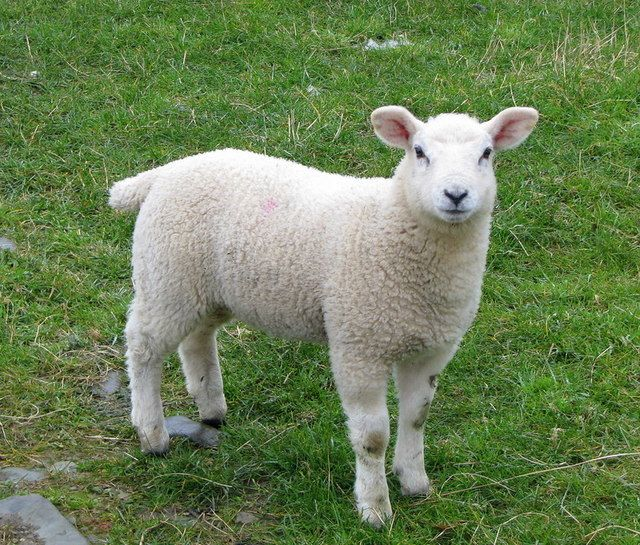

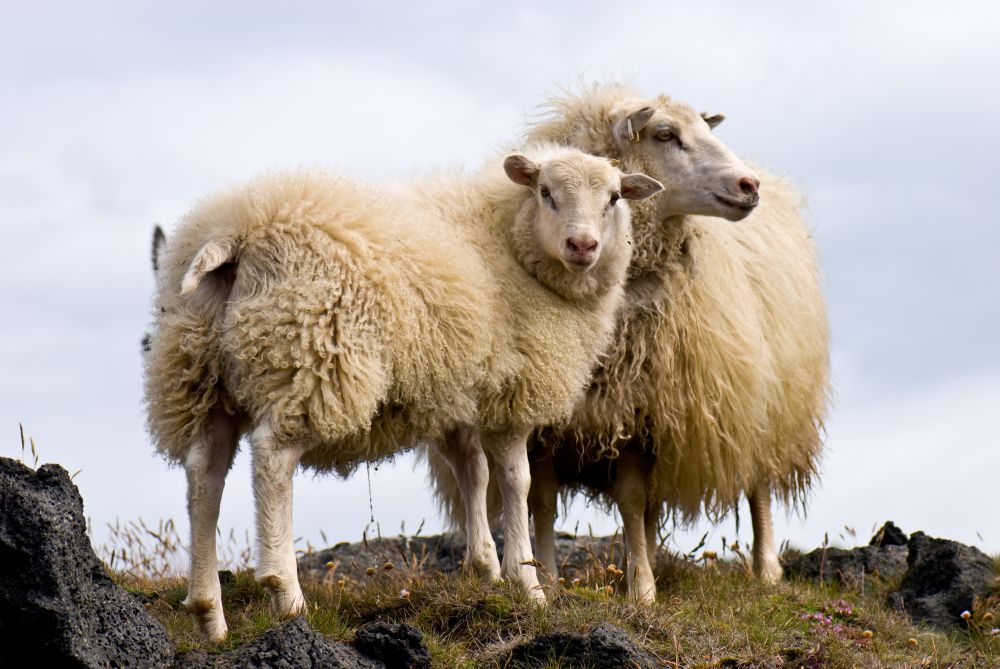

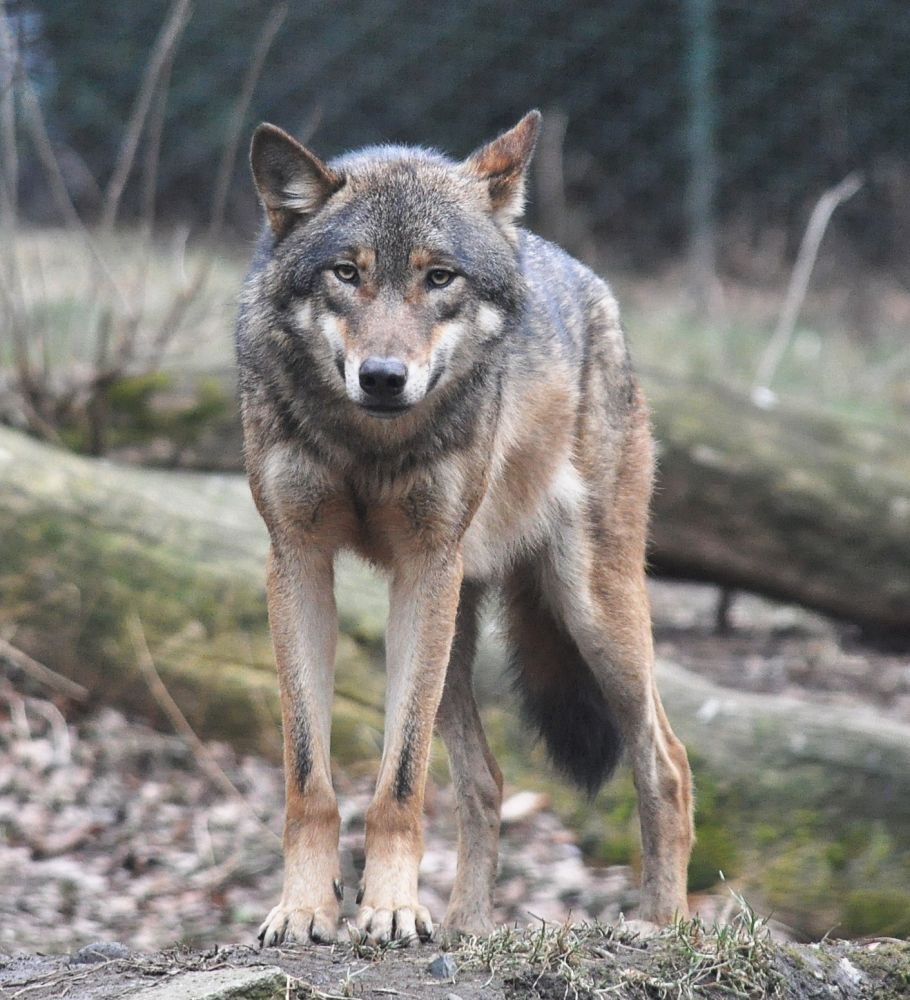

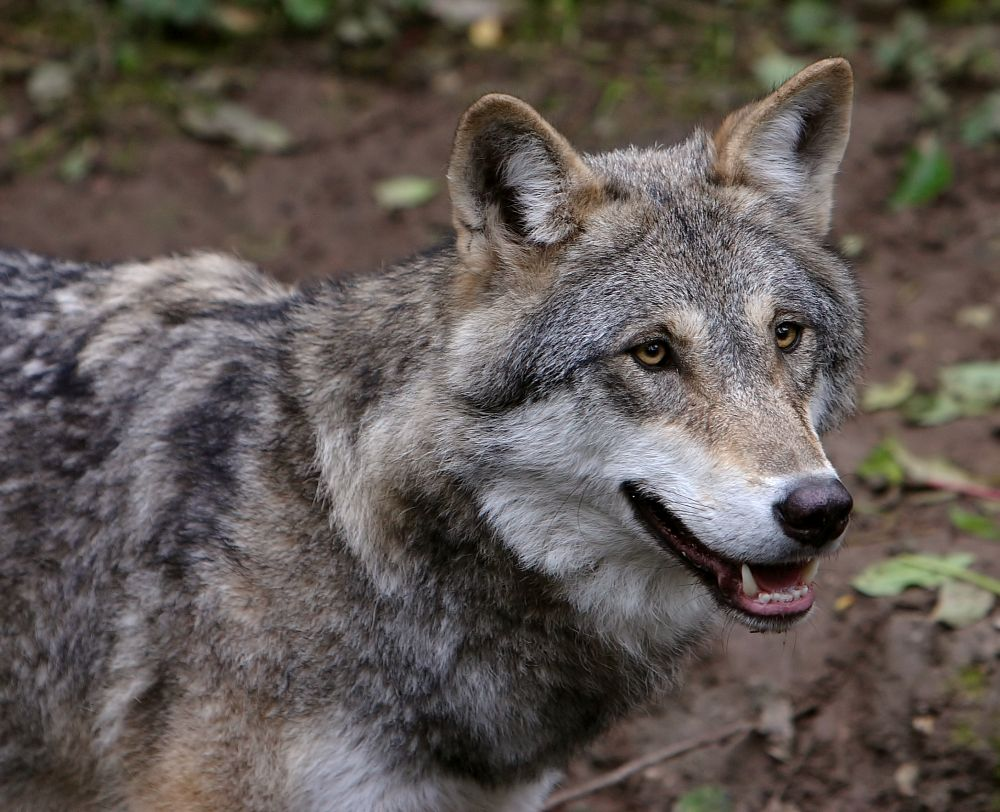

In [3]:
from cvworkshop_utils import download_resnet_model, download_animals_dataset
print('Downloading pre-trained model. Note: this might take a while...')
base_model_file = download_resnet_model()
print('Downloading pre-trained model complete!')
print('Downloading animals data-set, this might take a while...')
animals_data = download_animals_dataset()
print('All data now available to the notebook!')


sheep = ['738519_d0394de9.jpg', 'Pair_of_Icelandic_Sheep.jpg']
wolves = ['European_grey_wolf_in_Prague_zoo.jpg', 'Wolf_je1-3.jpg']
for image in [os.path.join('Sheep', f) for f in sheep] + [os.path.join('Wolf', f) for f in wolves]:
    D.display(D.Image(os.path.join(animals_data['training_folder'], image), width=200, height=200))

# Part 6 Preprocess Dataset
We will need to create class mappings for our data we will define the following functions to enable this.

In [4]:
# Set python version variable 
python_version = sys.version_info.major

def create_map_file_from_folder(root_folder, class_mapping, include_unknown=False, valid_extensions=['.jpg', '.jpeg', '.png']):
    map_file_name = os.path.join(root_folder, "map.txt")
    
    map_file = None

    if python_version == 3: 
        map_file = open(map_file_name , 'w', encoding='utf-8')
    else:
        map_file = open(map_file_name , 'w')

    for class_id in range(0, len(class_mapping)):
        folder = os.path.join(root_folder, class_mapping[class_id])
        if os.path.exists(folder):
            for entry in os.listdir(folder):
                filename = os.path.abspath(os.path.join(folder, entry))
                if os.path.isfile(filename) and os.path.splitext(filename)[1].lower() in valid_extensions:
                    try:
                        map_file.write("{0}\t{1}\n".format(filename, class_id))
                    except UnicodeEncodeError:
                        continue

    if include_unknown:
        for entry in os.listdir(root_folder):
            filename = os.path.abspath(os.path.join(root_folder, entry))
            if os.path.isfile(filename) and os.path.splitext(filename)[1].lower() in valid_extensions:
                try:
                    map_file.write("{0}\t-1\n".format(filename))
                except UnicodeEncodeError:
                    continue
                    
    map_file.close()  
    
    return map_file_name
  

def create_class_mapping_from_folder(root_folder):
    classes = []
    for _, directories, _ in os.walk(root_folder):
        for directory in directories:
            classes.append(directory)
    return np.asarray(classes)

animals_data['class_mapping'] = create_class_mapping_from_folder(animals_data['training_folder'])
animals_data['training_map'] = create_map_file_from_folder(animals_data['training_folder'], animals_data['class_mapping'])
animals_data['testing_map'] = create_map_file_from_folder(animals_data['testing_folder'], animals_data['class_mapping'], include_unknown=True)
                            

# Part 6 Inspecting pre-trained model

We print out all of the layers in ResNet_18 to show you how you can interrogate a model - to use a different model than ResNet_18 you would just need to discover the appropriate last hidden layer and feature layer to use. CNTK provides a convenient `get_node_outputs` method under `cntk.graph` to allow you to dump all of the model details. We can recognize the final hidden layer as the one before we start computing the final classification into the 1000 ImageNet classes (so in this case, `z.x`).

In [5]:
# define base model location and characteristics
base_model = {
    'model_file': base_model_file,
    'feature_node_name': 'features',
    'last_hidden_node_name': 'z.x',
    # Channel Depth x Height x Width
    'image_dims': (3, 224, 224)
}

# Print out all layers in the model
print('Loading {} and printing all layers:'.format(base_model['model_file']))
node_outputs = C.logging.get_node_outputs(C.load_model(base_model['model_file']))
for l in node_outputs: print("  {0} {1}".format(l.name, l.shape))

Loading models/resnet/ResNet_18.model and printing all layers:
  ce ()
  errs ()
  top5Errs ()
  z (1000,)
  ce ()
  z (1000,)
  z.PlusArgs[0] (1000,)
  z.x (512, 1, 1)
  z.x.x.r (512, 7, 7)
  z.x.x.p (512, 7, 7)
  z.x.x.b (512, 7, 7)
  z.x.x.b.x.c (512, 7, 7)
  z.x.x.b.x (512, 7, 7)
  z.x.x.b.x._ (512, 7, 7)
  z.x.x.b.x._.x.c (512, 7, 7)
  z.x.x.x.r (512, 7, 7)
  z.x.x.x.p (512, 7, 7)
  z.x.x.x.b (512, 7, 7)
  z.x.x.x.b.x.c (512, 7, 7)
  z.x.x.x.b.x (512, 7, 7)
  z.x.x.x.b.x._ (512, 7, 7)
  z.x.x.x.b.x._.x.c (512, 7, 7)
  _z.x.x.x.r (512, 7, 7)
  _z.x.x.x.p (512, 7, 7)
  _z.x.x.x.b (512, 7, 7)
  _z.x.x.x.b.x.c (512, 7, 7)
  _z.x.x.x.b.x (512, 7, 7)
  _z.x.x.x.b.x._ (512, 7, 7)
  _z.x.x.x.b.x._.x.c (512, 7, 7)
  z.x.x.x.x.r (256, 14, 14)
  z.x.x.x.x.p (256, 14, 14)
  z.x.x.x.x.b (256, 14, 14)
  z.x.x.x.x.b.x.c (256, 14, 14)
  z.x.x.x.x.b.x (256, 14, 14)
  z.x.x.x.x.b.x._ (256, 14, 14)
  z.x.x.x.x.b.x._.x.c (256, 14, 14)
  z.x.x.x.x.x.r (256, 14, 14)
  z.x.x.x.x.x.p (256, 14, 14)
  z.x.

# Part 7 Training the Transfer Learning Model

In the code below, we load up the pre-trained ResNet_18 model and clone it, while stripping off the final `features` layer. We clone the model so that we can re-use the same trained model multiple times, trained for different things - it is not strictly necessary if you are just training it for a single task, but this is why we would not use `CloneMethod.share`, we want to learn new parameters. If `freeze_weights` is true, we will freeze weights on all layers we clone and only learn weights on the final new features layer. This can often be useful if you are cloning higher up the tree (e.g., cloning after the first convolutional layer to just get basic image features).

We find the final hidden layer (`z.x`) using `find_by_name`, clone it and all of its predecessors, then attach a new `Dense` layer for classification.

There are two run modes:
- *Fast mode*: `isFast` is set to `True`. This is the default mode for the notebooks, which means we train for fewer iterations or train / test on limited data. This ensures functional correctness of the notebook though the models produced are far from what a completed training would produce.

- *Slow mode*: We recommend the user to set this flag to `False` once the user has gained familiarity with the notebook content and wants to gain insight from running the notebooks for a longer period with different parameters for training. 

For *Fast mode* we train the model for 100 epochs and results have low accuracy but is good enough for development. The model yields good accuracy after 1000-2000 epochs.

In [6]:
isFast = True

In [7]:
import cntk.io.transforms as xforms
from cvworkshop_utils import ensure_exists
output_path = "output/part3"
ensure_exists(output_path)
np.random.seed(123)

# Creates a minibatch source for training or testing
def create_mb_source(map_file, image_dims, num_classes, randomize=True):
    transforms = [xforms.scale(width=image_dims[2], height=image_dims[1], channels=image_dims[0], interpolations='linear')]
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
            features=C.io.StreamDef(field='image', transforms=transforms),
            labels=C.io.StreamDef(field='label', shape=num_classes))),
            randomize=randomize)

# Creates the network model for transfer learning
def create_model(model_details, num_classes, input_features, new_prediction_node_name='prediction', freeze=False):
    # Load the pretrained classification net and find nodes
    base_model = C.load_model(model_details['model_file'])
    feature_node = C.logging.find_by_name(base_model, model_details['feature_node_name'])
    last_node = C.logging.find_by_name(base_model, model_details['last_hidden_node_name'])

    # Clone the desired layers with fixed weights
    cloned_layers = C.combine([last_node.owner]).clone(
        C.CloneMethod.freeze if freeze else C.CloneMethod.clone,
        {feature_node: C.placeholder(name='features')})

    # Add new dense layer for class prediction
    feat_norm = input_features - C.Constant(114)
    cloned_out = cloned_layers(feat_norm)
    z = C.layers.Dense(num_classes, activation=None, name=new_prediction_node_name) (cloned_out)

    return z

We will now train the model just like any other CNTK model training - instantiating an input source (in this case a `MinibatchSource` from our image data), defining the loss function, and training for a number of epochs. Since we are training a multi-class classifier network, the final layer is a cross-entropy Softmax, and the error function is classification error - both conveniently provided by utility functions in `cntk.ops`.

When training a pre-trained model, we are adapting the existing weights to suit our domain. Since the weights are likely already close to correct (especially for earlier layers that find more primitive features), fewer examples and fewer epochs are typically required to get good performance.

In [8]:
# Trains a transfer learning model
def train_model(model_details, num_classes, train_map_file,
                learning_params, max_images=-1):
    num_epochs = learning_params['max_epochs']
    epoch_size = sum(1 for line in open(train_map_file))
    if max_images > 0:
        epoch_size = min(epoch_size, max_images)
    minibatch_size = learning_params['mb_size']
    
    # Create the minibatch source and input variables
    minibatch_source = create_mb_source(train_map_file, model_details['image_dims'], num_classes)
    image_input = C.input_variable(model_details['image_dims'])
    label_input = C.input_variable(num_classes)

    # Define mapping from reader streams to network inputs
    input_map = {
        image_input: minibatch_source['features'],
        label_input: minibatch_source['labels']
    }

    # Instantiate the transfer learning model and loss function
    tl_model = create_model(model_details, num_classes, image_input, freeze=learning_params['freeze_weights'])
    ce = C.cross_entropy_with_softmax(tl_model, label_input)
    pe = C.classification_error(tl_model, label_input)

    # Instantiate the trainer object
    lr_schedule = C.learning_rate_schedule(learning_params['lr_per_mb'], unit=C.UnitType.minibatch)
    mm_schedule = C.momentum_schedule(learning_params['momentum_per_mb'])
    learner = C.adam(tl_model.parameters, lr_schedule, mm_schedule, 
                           l2_regularization_weight=learning_params['l2_reg_weight'])
    trainer = C.Trainer(tl_model, (ce, pe), learner)

    # Get minibatches of images and perform model training
    print("Training transfer learning model for {0} epochs (epoch_size = {1}).".format(num_epochs, epoch_size))
    C.logging.log_number_of_parameters(tl_model)
    progress_printer = C.logging.ProgressPrinter(tag='Training', num_epochs=num_epochs)
    for epoch in range(num_epochs):       # loop over epochs
        sample_count = 0
        while sample_count < epoch_size:  # loop over minibatches in the epoch
            data = minibatch_source.next_minibatch(min(minibatch_size, epoch_size - sample_count), input_map=input_map)
            trainer.train_minibatch(data)                                    # update model with it
            sample_count += trainer.previous_minibatch_sample_count          # count samples processed so far
            progress_printer.update_with_trainer(trainer, with_metric=True)  # log progress
            if sample_count % (100 * minibatch_size) == 0:
                print ("Processed {0} samples".format(sample_count))

        progress_printer.epoch_summary(with_metric=True)

    return tl_model

When we evaluate the trained model on an image, we have to massage that image into the expected format. In our case we use `Image` to load the image from its path, resize it to the size expected by our model, reverse the color channels (RGB to BGR), and convert to a contiguous array along height, width, and color channels. This corresponds to the 224x224x3 flattened array on which our model was trained.

The model with which we are doing the evaluation has not had the Softmax and Error layers added, so is complete up to the final feature layer. To evaluate the image with the model, we send the input data to the `model.eval` method, `softmax` over the results to produce probabilities, and use Numpy's `argmax` method to determine the predicted class. We can then compare that against the true labels to get the overall model accuracy.

In [9]:
# Evaluates a single image using the re-trained model
def eval_single_image(loaded_model, image_path, image_dims):
    # load and format image (resize, RGB -> BGR, CHW -> HWC)
    try:
        img = Image.open(image_path)
        
        if image_path.endswith("png"):
            temp = Image.new("RGB", img.size, (255, 255, 255))
            temp.paste(img, img)
            img = temp
        resized = img.resize((image_dims[2], image_dims[1]), Image.ANTIALIAS)
        bgr_image = np.asarray(resized, dtype=np.float32)[..., [2, 1, 0]]
        hwc_format = np.ascontiguousarray(np.rollaxis(bgr_image, 2))

        # compute model output
        arguments = {loaded_model.arguments[0]: [hwc_format]}
        output = loaded_model.eval(arguments)

        # return softmax probabilities
        sm = C.softmax(output[0])
        return sm.eval()
    except FileNotFoundError:
        print("Could not open (skipping file): ", image_path)
        return ['None']
        

# Evaluates an image set using the provided model
def eval_test_images(loaded_model, output_file, test_map_file, image_dims, max_images=-1, column_offset=0):
    num_images = sum(1 for line in open(test_map_file))
    if max_images > 0:
        num_images = min(num_images, max_images)
    if isFast:
        num_images = min(num_images, 300) #We will run through fewer images for test run
        
    print("Evaluating model output node '{0}' for {1} images.".format('prediction', num_images))

    pred_count = 0
    correct_count = 0
    np.seterr(over='raise')
    with open(output_file, 'wb') as results_file:
        with open(test_map_file, "r") as input_file:
            for line in input_file:
                tokens = line.rstrip().split('\t')
                img_file = tokens[0 + column_offset]
                probs = eval_single_image(loaded_model, img_file, image_dims)
                
                if probs[0]=='None':
                    print("Eval not possible: ", img_file)
                    continue

                pred_count += 1
                true_label = int(tokens[1 + column_offset])
                predicted_label = np.argmax(probs)
                if predicted_label == true_label:
                    correct_count += 1

                #np.savetxt(results_file, probs[np.newaxis], fmt="%.3f")
                if pred_count % 100 == 0:
                    print("Processed {0} samples ({1:.2%} correct)".format(pred_count, 
                                                                           (float(correct_count) / pred_count)))
                if pred_count >= num_images:
                    break
    print ("{0} of {1} prediction were correct".format(correct_count, pred_count))
    return correct_count, pred_count, (float(correct_count) / pred_count)

Finally, with all of these helper functions in place we can train the model and evaluate it on our flower dataset.

Feel free to adjust the `learning_params` below and observe the results. You can tweak the `max_epochs` to train for longer, `mb_size` to adjust the size of each minibatch, or `lr_per_mb` to play with the speed of convergence (learning rate). 

**Note that if you've already trained the model, you will want to set `force_retraining` to `True` to force the Notebook to re-train your model with the new parameters.** 

In [10]:
#Train the animals model
force_retraining = True

max_training_epochs = 5 if isFast else 20

learning_params = {
    'max_epochs': max_training_epochs,
    'mb_size': 50,
    'lr_per_mb': [0.2]*10 + [0.1],
    'momentum_per_mb': 0.9,
    'l2_reg_weight': 0.0005,
    'freeze_weights': True
}

animals_model = {
    'model_file': os.path.join(output_path, 'AnimalsTransferLearning.model'),
    'results_file': os.path.join(output_path, 'AnimalsPredictions.txt'),
    'num_classes': len(animals_data['class_mapping'])
}

In [11]:
if os.path.exists(animals_model['model_file']) and not force_retraining:
    print("Loading existing model from %s" % animals_model['model_file'])
    trained_model = C.load_model(animals_model['model_file'])
else:
    trained_model = train_model(base_model, 
                                animals_model['num_classes'], animals_data['training_map'],
                                learning_params)
    trained_model.save(animals_model['model_file'])
    print("Stored trained model at %s" % animals_model['model_file'])

Training transfer learning model for 5 epochs (epoch_size = 30).
Training 1026 parameters in 2 parameter tensors.
Finished Epoch[1 of 5]: [Training] loss = 0.796682 * 30, metric = 40.00% * 30 2.138s ( 14.0 samples/s);
Finished Epoch[2 of 5]: [Training] loss = 0.457008 * 30, metric = 26.67% * 30 1.231s ( 24.4 samples/s);
Finished Epoch[3 of 5]: [Training] loss = 0.128421 * 30, metric = 3.33% * 30 1.222s ( 24.5 samples/s);
Finished Epoch[4 of 5]: [Training] loss = 0.101541 * 30, metric = 3.33% * 30 1.434s ( 20.9 samples/s);
Finished Epoch[5 of 5]: [Training] loss = 0.049142 * 30, metric = 0.00% * 30 1.360s ( 22.1 samples/s);
Stored trained model at output/part3/AnimalsTransferLearning.model


You should see the model train and evaluate, with a final accuracy somewhere in the realm of 94%. At this point you could choose to train longer, or consider taking a look at the confusion matrix to determine if certain flowers are mis-predicted at a greater rate. You could also easily swap out to a different model and see if that performs better, or potentially learn from an earlier point in the model architecture.

In [12]:
### Evaluate test images

In [13]:
with open(animals_data['testing_map'], 'r') as input_file:
    for line in input_file:
        tokens = line.rstrip().split('\t')
        img_file = tokens[0]
        true_label = int(tokens[1])
        probs = eval_single_image(trained_model, img_file, base_model['image_dims'])

        if probs[0]=='None':
            continue
        class_probs = np.column_stack((probs, animals_data['class_mapping'])).tolist()
        class_probs.sort(key=lambda x: float(x[0]), reverse=True)
        predictions = ' '.join(['%s:%.3f' % (class_probs[i][1], float(class_probs[i][0])) \
                                for i in range(0, animals_model['num_classes'])])
        true_class_name = animals_data['class_mapping'][true_label] if true_label >= 0 else 'unknown'
        print('Class: %s, predictions: %s, image: %s' % (true_class_name, predictions, img_file))

Class: Wolf, predictions: Wolf:0.977 Sheep:0.023, image: /cv_workshop/dataset/Animals/Test/Wolf/9-wolf-profile-full.jpg
Class: Wolf, predictions: Wolf:0.991 Sheep:0.009, image: /cv_workshop/dataset/Animals/Test/Wolf/Kolmarden_Wolf.jpg
Class: Wolf, predictions: Wolf:0.746 Sheep:0.254, image: /cv_workshop/dataset/Animals/Test/Wolf/The_white_wolf_by_Lunchi.jpg
Class: Wolf, predictions: Wolf:0.991 Sheep:0.009, image: /cv_workshop/dataset/Animals/Test/Wolf/Iberian_Wolf.jpg
Class: Wolf, predictions: Wolf:0.995 Sheep:0.005, image: /cv_workshop/dataset/Animals/Test/Wolf/Canis_lupus_occidentalis.jpg
Class: Sheep, predictions: Sheep:0.967 Wolf:0.033, image: /cv_workshop/dataset/Animals/Test/Sheep/Swaledale_sheep.jpg
Class: Sheep, predictions: Sheep:0.864 Wolf:0.136, image: /cv_workshop/dataset/Animals/Test/Sheep/Icelandic_breed_sheep.jpg
Class: Sheep, predictions: Sheep:0.704 Wolf:0.296, image: /cv_workshop/dataset/Animals/Test/Sheep/Icelandic_sheep_summer_06.jpg
Class: Sheep, predictions: Sheep

# Part 8 With Our Beverage Policy Dataset

Lets try to use transfer learning and resnet to clasify our Beverage policy

The images are stored in `Train` and `Test` folders with the nested folder giving the class name (i.e. `Valid` and `Invalid` folders). This is quite common, so it is useful to know how to convert that format into one that can be used for constructing the mapping files CNTK expects. `create_class_mapping_from_folder` looks at all nested folders in the root and turns their names into labels, and returns this as an array used by `create_map_file_from_folder`. That method walks those folders and writes their paths and label indices into a `map.txt` file in the root (e.g. `Train`, `Test`). Note the use of `abspath`, allowing you to specify relative "root" paths to the method, and then move the resulting map files or run from different directories without issue. 

**By Default this notebook uses CPU if you want to train your own model set GPU to True**

In [14]:
training_folder = 'dataset/Recognition/Train'
testing_folder = 'dataset/Recognition/Test'

class_mapping = create_class_mapping_from_folder(training_folder)
training_map = create_map_file_from_folder(training_folder, class_mapping)
testing_map = create_map_file_from_folder(testing_folder, class_mapping, include_unknown=True)

max_training_epochs = 5 if isFast else 20

learning_params = {
    'max_epochs': max_training_epochs,
    'mb_size': 50,
    'lr_per_mb': [0.2]*10 + [0.1],
    'momentum_per_mb': 0.045,
    'l2_reg_weight': 0.0005,
    'freeze_weights': True
}

beverage_policy_model = {
    'model_file': os.path.join(output_path, 'BevereagesPolicy.model'),
    'results_file': os.path.join(output_path, 'BevereagesPolicy.txt'),
    'num_classes': len(class_mapping)
}


We can now train our model on our small domain and evaluate the results:

**To save time for those using CPU's we will download a pretrained model if you have GPU feel free to set force_retraining = True and experiment training the model yourself.**

In [15]:
force_retraining = False

if not force_retraining:
    from cvworkshop_utils import ensure_exists, download_unless_exists
    ensure_exists(output_path)
    model_uri = 'https://computervisionworkshop.blob.core.windows.net/models/BevereagesPolicy.model'
    model_path = os.path.join(output_path, 'BevereagesPolicy.model')
    download_unless_exists(model_uri, model_path)

if os.path.exists(beverage_policy_model['model_file']) and not force_retraining:
    print("Loading existing model from %s" % beverage_policy_model['model_file'])
    trained_model = C.load_model(beverage_policy_model['model_file'])
else:
    C.device.try_set_default_device(C.device.gpu(0))
    trained_model = train_model(base_model, 
                                beverage_policy_model['num_classes'], training_map,
                                learning_params)
    trained_model.save(beverage_policy_model['model_file'])
    print("Stored trained model at %s" % beverage_policy_model['model_file'])

Starting download of https://computervisionworkshop.blob.core.windows.net/models/BevereagesPolicy.model to output/part3/BevereagesPolicy.model
...100%, 60 MB, 844 KB/s, 73 seconds passedDownload completed.
Loading existing model from output/part3/BevereagesPolicy.model


### Now that the model is trained for beverage policy data. Lets us evaluate the results and compare.

In [16]:
def predict(token):
    img_file = token[0]
    true_label = int(token[1])
    probs = eval_single_image(trained_model, img_file, base_model['image_dims'])
    class_probs = np.column_stack((probs, class_mapping)).tolist()
    class_probs.sort(key=lambda x: float(x[0]), reverse=True)
    predictions = [(class_probs[i][1], float(class_probs[i][0])) for i in range(0, beverage_policy_model['num_classes'])]
    result_label = max(predictions, key=lambda x:x[1])[0]
    return (class_mapping[true_label], result_label)
         
tokens = []
with open(testing_map, 'r') as input_file:
    tokens = [line.rstrip().split('\t') for line in input_file]    
y_true, y_pred = zip(*[predict(t) for t in tokens])

             precision    recall  f1-score   support

    Invalid       0.83      0.97      0.89        30
      Valid       0.96      0.80      0.87        30

avg / total       0.89      0.88      0.88        60

Confusion matrix, without normalization
[[29  1]
 [ 6 24]]
Normalized confusion matrix
[[ 0.97  0.03]
 [ 0.2   0.8 ]]


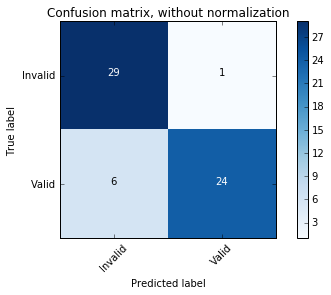

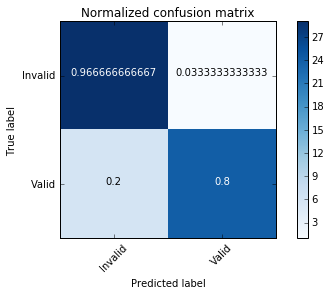

In [17]:
from cvworkshop_utils import classification_report

classification_report(y_true, y_pred)

### Final Thoughts, and Caveats

Transfer Learning has limitations. If you noticed, we re-trained a model that had been trained on ImageNet images. This meant it already _knew_ what "images" were, and had a good idea on concepts from low-level (stripes, circles) to high-level (dog's noses, cat's ears). Re-training such a model to detect sheep or wolves makes sense, but re-training it to detect vehicles from aerial imagery would be more difficult. You can still use Transfer Learning in these cases, but you might want to just re-use earlier layers of the model (i.e. the early Convolutional layers that have learned more primitive concepts), and you will likely require much more training data.

When applied to our own dataset the model overfit and predicted policy with about the same accuracy as a coin flip this means that we need more complex methods if we want to train a more acurate classifier.